In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score,roc_auc_score,confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import optuna

**EDA**

In [3]:
training_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
output_data=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

<Axes: xlabel='Survived', ylabel='count'>

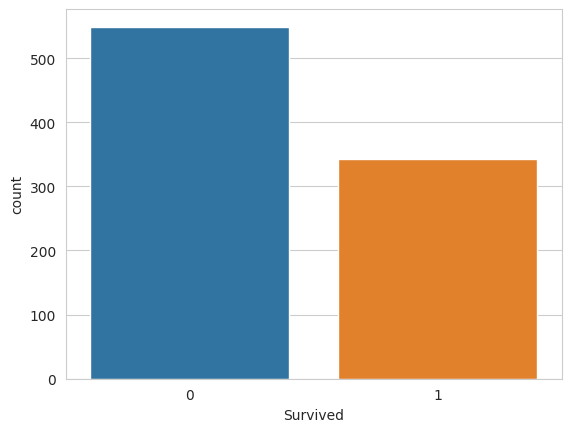

In [4]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=training_data)

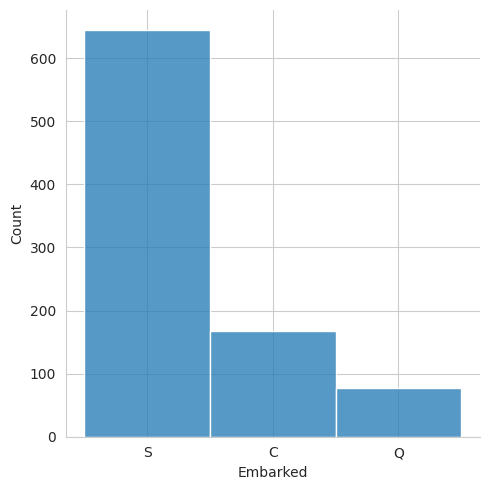

In [5]:
sns.displot(data=training_data,x='Embarked')

In [6]:
embarked_mode = training_data['Embarked'].mode()[0]
training_data['Embarked'].fillna(embarked_mode, inplace=True)

<Axes: xlabel='Survived', ylabel='count'>

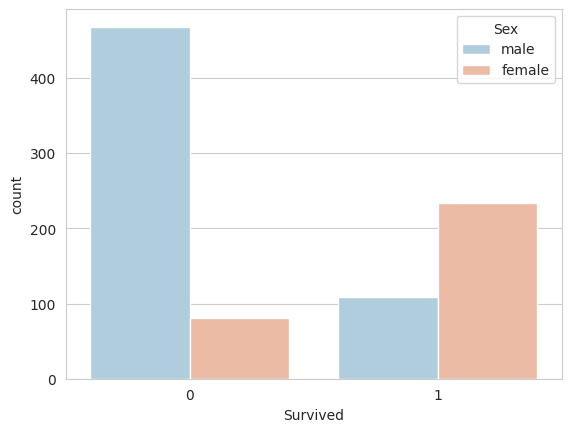

In [7]:
sns.countplot(x='Survived',data=training_data,hue='Sex',palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

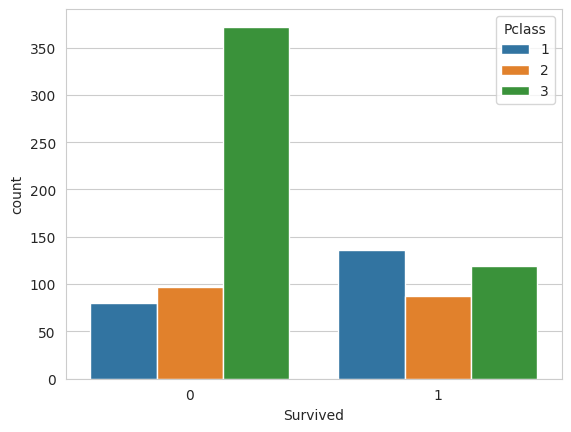

In [8]:
sns.countplot(x='Survived',data=training_data,hue='Pclass')

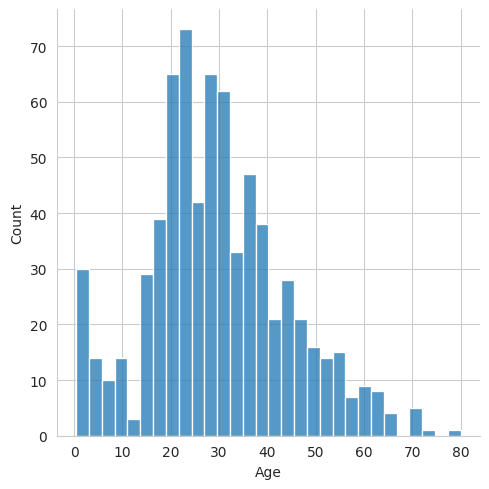

In [9]:
sns.displot(training_data['Age'],kde=False,bins=30)

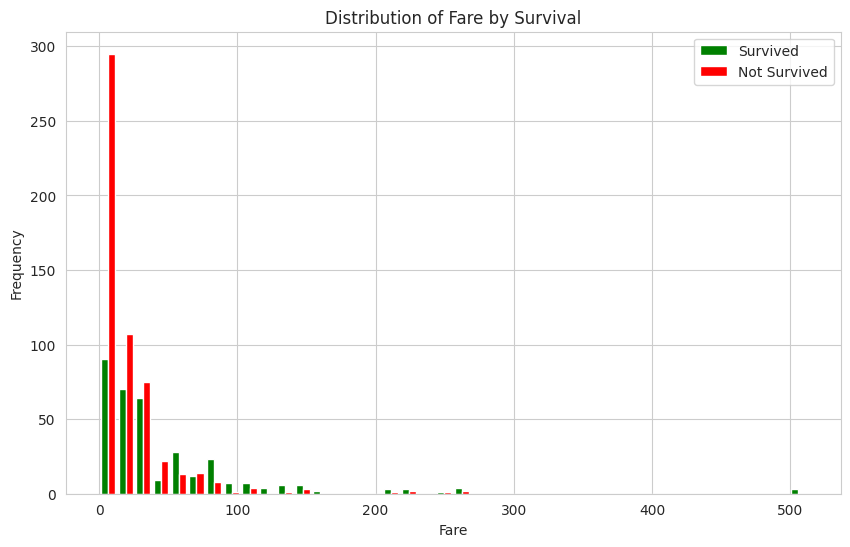

In [10]:
survived_fares = training_data[training_data['Survived'] == 1]['Fare']
not_survived_fares = training_data[training_data['Survived'] == 0]['Fare']

plt.figure(figsize=(10, 6))
plt.hist([survived_fares, not_survived_fares], bins=40, color=['green', 'red'], label=['Survived', 'Not Survived'])
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Distribution of Fare by Survival')
plt.legend()
plt.show()

**DATA PREPROCESSING**

<Axes: >

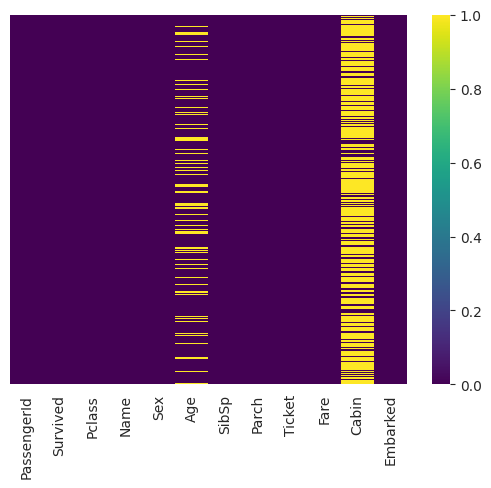

In [11]:
sns.heatmap(training_data.isnull(),yticklabels=False,cmap=('viridis'))

<Axes: >

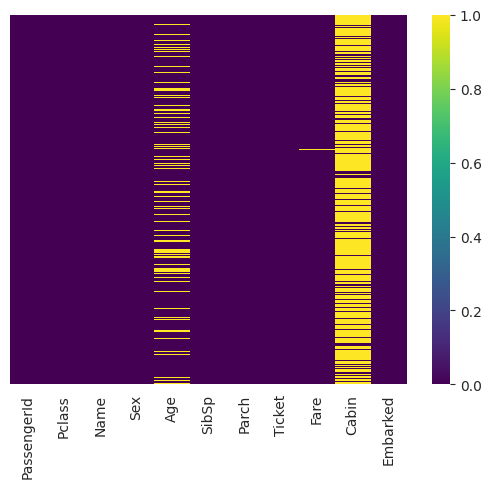

In [12]:
sns.heatmap(test_data.isnull(),yticklabels=False,cmap=('viridis'))

In [13]:
training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
def preprocess(data):
    data['Title'] = data.Name.str.extract(r' ([A-Za-z]+)\.', expand=False)
    #regex expression "r' ([A-Za-z]+)\.'" is used here.
    #"r'..'" indicates raw string literal.
    #"()" captures the specific part inside them. "[A-Za-z]+" captures any lowercase or uppercase letters in succession.
    #"\." backslash here is used to treat "." as a character instead of its meaning in a regex expression.
    data.Title = data.Title.replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data.Title = data.Title.replace('Mlle', 'Miss')
    data.Title = data.Title.replace('Ms', 'Miss')
    data.Title = data.Title.replace('Mme', 'Mrs')
    
    encoder_title = OneHotEncoder(sparse_output=False, drop='first')
    title_encoded = encoder_title.fit_transform(data[['Title']])
    
    title_encoded_df = pd.DataFrame(title_encoded, columns=encoder_title.get_feature_names_out(['Title'])).astype(int)
    
    data = pd.concat([data, title_encoded_df], axis=1)
    
    data.drop('Title', axis=1, inplace=True)
    
    encoder_embarked = OneHotEncoder(sparse_output=False, drop='first')
    embarked_encoded = encoder_embarked.fit_transform(data[['Embarked']])
    embarked_encoded_df = pd.DataFrame(embarked_encoded, columns=encoder_embarked.get_feature_names_out(['Embarked'])).astype(int)
    data = pd.concat([data, embarked_encoded_df], axis=1)
    
    encoder_Sex = OneHotEncoder(sparse_output=False, drop='first')
    Sex_encoded = encoder_Sex.fit_transform(data[['Sex']])
    Sex_encoded_df = pd.DataFrame(Sex_encoded, columns=encoder_Sex.get_feature_names_out(['Sex'])).astype(int)
    data = pd.concat([data, Sex_encoded_df], axis=1)
    
    encoder_Pclass = OneHotEncoder(sparse_output=False, drop='first')
    Pclass_encoded = encoder_Pclass.fit_transform(data[['Pclass']])
    Pclass_encoded_df = pd.DataFrame(Pclass_encoded, columns=encoder_Pclass.get_feature_names_out(['Pclass'])).astype(int)
    data = pd.concat([data, Pclass_encoded_df], axis=1)
    
    data['Fare'] = data['Fare'].fillna(np.mean(data['Fare']))
    
    data.drop(['Sex', 'Pclass', 'Embarked', 'Name', 'PassengerId','Cabin','Ticket'], axis=1, inplace=True)
    
    return data

In [15]:
test_data_passenger_id = test_data.PassengerId
training_data=preprocess(training_data)
test_data=preprocess(test_data)

In [16]:
training_data.head()

,Survived,Age,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0,1,0,0,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,1,0,0,0,0,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,0,0,1,0,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,0,1,1,0,1


In [17]:
test_data.head()

,Age,SibSp,Parch,Fare,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,34.5,0,0,7.8292,0,1,0,0,1,0,1,0,1
1,47.0,1,0,7.0000,0,0,1,0,0,1,0,0,1
2,62.0,0,0,9.6875,0,1,0,0,1,0,1,1,0
3,27.0,0,0,8.6625,0,1,0,0,0,1,1,0,1
4,22.0,1,1,12.2875,0,0,1,0,0,1,0,0,1


In [18]:
def fill_age(data):
    median_ages = data.groupby(['Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare'])['Age'].median()
    
    for index, row in data.iterrows():
        if pd.isnull(row['Age']):
            encoded_titles = (row['Title_Miss'], row['Title_Mr'], row['Title_Mrs'], row['Title_Rare'])
            median_age = median_ages.loc[encoded_titles]
            random_age = np.random.uniform(median_age - 2, median_age + 2)
            data.at[index, 'Age'] = random_age    
    return data

training_data = fill_age(training_data)
test_data = fill_age(test_data)

In [19]:
def add_features(data):
    # Family Size
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['IsAlone'] = 1
    data['IsAlone'].loc[data['FamilySize'] > 1] = 0

    data['FarePerPerson'] = data['Fare'] / data['FamilySize']
    data.drop('Fare', axis=1, inplace=True)
    
    return data

training_data = add_features(training_data)
test_data = add_features(test_data)

In [20]:
X = training_data.drop('Survived', axis=1)  # Features
y = training_data['Survived']

In [21]:
X.head(10)

,Age,SibSp,Parch,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3,FamilySize,IsAlone,FarePerPerson
0,22.000000,1,0,0,1,0,0,0,1,1,0,1,2,0,3.62500
1,38.000000,1,0,0,0,1,0,0,0,0,0,0,2,0,35.64165
2,26.000000,0,0,1,0,0,0,0,1,0,0,1,1,1,7.92500
3,35.000000,1,0,0,0,1,0,0,1,0,0,0,2,0,26.55000
4,35.000000,0,0,0,1,0,0,0,1,1,0,1,1,1,8.05000
5,28.431869,0,0,0,1,0,0,1,0,1,0,1,1,1,8.45830
6,54.000000,0,0,0,1,0,0,0,1,1,0,0,1,1,51.86250
7,2.000000,3,1,0,0,0,0,0,1,1,0,1,5,0,4.21500
8,27.000000,0,2,0,0,1,0,0,1,0,0,1,3,0,3.71110
9,14.000000,1,0,0,0,1,0,0,0,0,1,0,2,0,15.03540


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

**MODEL TRAINING**

In [23]:
for max_depth in (5,10,30,50,70,90,120):
    for n_estimator in (10,30,50,70,90):
        model= RandomForestClassifier(max_depth=max_depth,random_state=1,n_estimators=n_estimator)
        scores= cross_val_score(model,X,y,cv=5,scoring='accuracy')
        print("max_depth: ",max_depth," n_estimator: ",n_estimator," score:",scores.mean())

max_depth:  5  n_estimator:  10  score: 0.8293892411022534
max_depth:  5  n_estimator:  30  score: 0.8237775406440274
max_depth:  5  n_estimator:  50  score: 0.827154604230745
max_depth:  5  n_estimator:  70  score: 0.8282907538760906
max_depth:  5  n_estimator:  90  score: 0.8305191136777352
max_depth:  10  n_estimator:  10  score: 0.8260561170045821
max_depth:  10  n_estimator:  30  score: 0.8305316678174629
max_depth:  10  n_estimator:  50  score: 0.8271734354403366
max_depth:  10  n_estimator:  70  score: 0.8215617349821104
max_depth:  10  n_estimator:  90  score: 0.8204318624066286
max_depth:  30  n_estimator:  10  score: 0.8069675475488042
max_depth:  30  n_estimator:  30  score: 0.8047266336074319
max_depth:  30  n_estimator:  50  score: 0.8036093151716779
max_depth:  30  n_estimator:  70  score: 0.7991149331492059
max_depth:  30  n_estimator:  90  score: 0.7968614650681062
max_depth:  50  n_estimator:  10  score: 0.8069675475488042
max_depth:  50  n_estimator:  30  score: 0.804

In [24]:
param = [{'max_depth':list(range(2,30)),'n_estimators':list(range(10,90))}]
clf = GridSearchCV(RandomForestClassifier(),param,cv=5,scoring='accuracy',verbose=True, n_jobs=-1) 
clf.fit(X,y) 
print(clf.best_params_)
print(clf.best_score_)

"param = [{'max_depth':list(range(2,30)),'n_estimators':list(range(10,90))}]\nclf = GridSearchCV(RandomForestClassifier(),param,cv=5,scoring='accuracy',verbose=True, n_jobs=-1) \nclf.fit(X,y) \nprint(clf.best_params_)\nprint(clf.best_score_)"

In [25]:
model = RandomForestClassifier(max_depth=best_params_[max_depth],random_state=1,n_estimators=best_params_[n_estimators])
#model = RandomForestClassifier(max_depth=5,random_state=1,n_estimators=62)
model.fit(X,y)
result = model.predict(test_data)
output = pd.DataFrame({'PassengerId': test_data_passenger_id, 'Survived': result})
output.to_csv('submission.csv', index=False)